In [1]:
import os,math,random, gc,datetime
import platform
import logging
logging.getLogger().setLevel(logging.CRITICAL)

#package imports
import numpy as np
import pandas as pd
from tqdm import tqdm

#plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#local imports
from utils.helpers import find_play_type

#Stats imports
import statsmodels as sm

#File paths below
#check kaggle or local
if platform.platform() == 'Linux-5.15.133+-x86_64-with-glibc2.31':
    FILE_PATH = '/kaggle/input/nfl-big-data-bowl-2024'
else:
    FILE_PATH = './nfl-big-data-bowl-2024'
GAMES_PATH = os.path.join(FILE_PATH,'games.csv')
PLAYS_PATH = os.path.join(FILE_PATH,'plays.csv')
PLAYERS_PATH = os.path.join(FILE_PATH,'players.csv')
TACKLES_PATH = os.path.join(FILE_PATH,'tackles.csv')

#Tracking weeks
WEEK1_PATH = os.path.join(FILE_PATH,'tracking_week_1.csv')

## Load Data

In [2]:
#base data
games_df = pd.read_csv(GAMES_PATH)
players_df = pd.read_csv(PLAYERS_PATH)
plays_df = pd.read_csv(PLAYS_PATH)
tackles_df = pd.read_csv(TACKLES_PATH)

#tracking week 1
week1_df = pd.read_csv(WEEK1_PATH)

In [3]:
#example of content
display(games_df.head(2))
display(players_df.head(2))
display(plays_df.head(2))
display(tackles_df.head(2))

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27


,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters


,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN


,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0
1,2022090800,393,46232,1,0,0,0


# EDA
### Tracking week data

Each tracking week file contains all games for the week as well as a number of plays, and the position of every player on the field during that play

In [4]:
#get all week1_games
week1_games = week1_df['gameId'].unique()
qb_df = players_df[players_df['position']=='QB']

game_1 = week1_df[week1_df['gameId'] == week1_games[0]]

display(game_1.head(2))
print('Total number of plays in this game data: {}'.format(len(game_1.playId.unique())))
print('Number of players in this game data: {}'.format(len(game_1.nflId.unique())))



,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived


Total number of plays in this game data: 91
Number of players in this game data: 68


Description:
(15:00) (Shotgun) J.Allen pass short right to S.Diggs to BUF 31 for 6 yards (J.Ramsey).


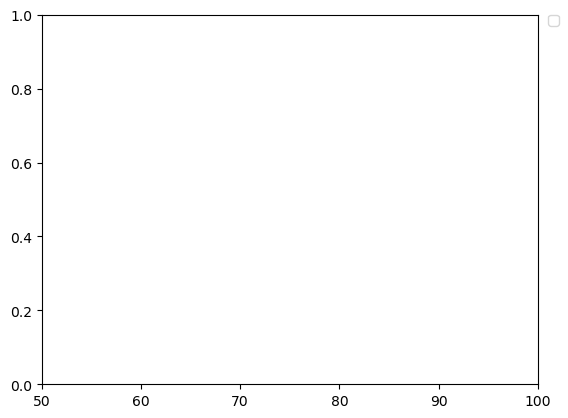

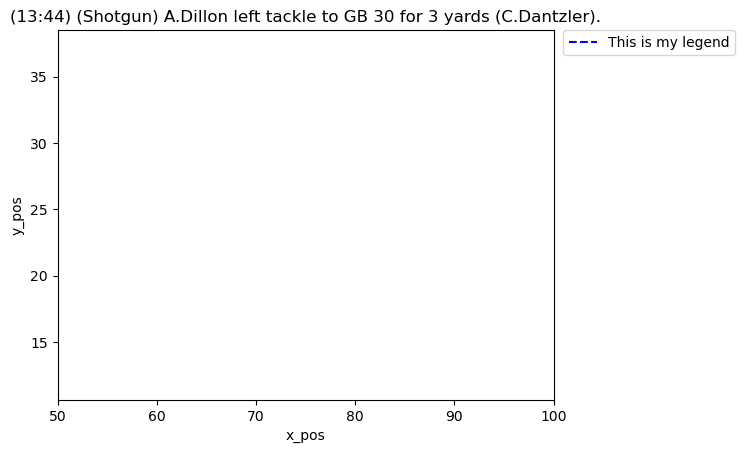

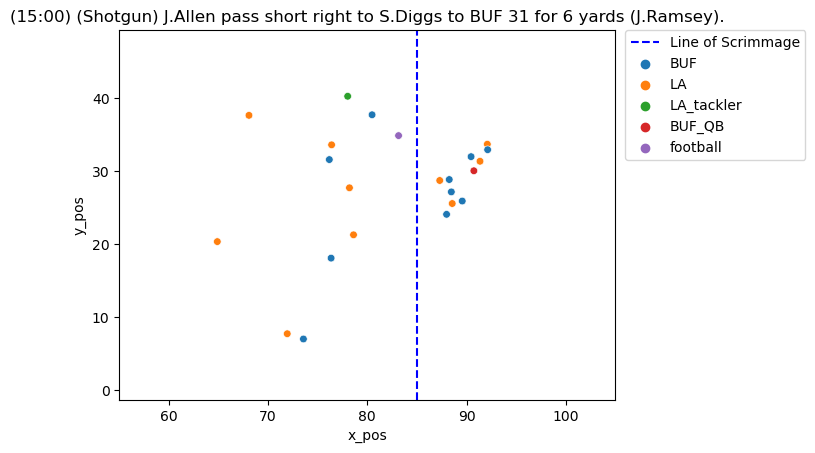

In [17]:
%matplotlib inline


def plot_play_frame(df, gameid=2022100908, playid=56, frame=0):
    play1_plot = pd.DataFrame()

    game = df[df['gameId'] == gameid]
    play_1 = game[game['playId']==playid]
    game_tackles = tackles_df[tackles_df['gameId']==gameid]
    play_data = plays_df[(plays_df['playId']==playid) & (plays_df['gameId']==gameid)]
    yard_line = play_data['absoluteYardlineNumber'].values[0]

    #football nflId is NaN. Should change
    for player in play_1['displayName'].unique():
        #first play,frame only test
        player_data = play_1[play_1['displayName']==player]
        play1_plot.loc[player,'x_pos'] = player_data['x'].iloc[frame]
        play1_plot.loc[player,'y_pos'] = player_data['y'].iloc[frame]
        play1_plot.loc[player,'team'] = player_data['club'].iloc[frame]
        play1_plot.loc[player,'id'] = player_data['nflId'].iloc[frame]


    for row in play1_plot.iterrows():
        if row[1]['id'] in game_tackles[game_tackles['playId']==playid]['nflId'].values:
            play1_plot.loc[row[0],'team'] = play1_plot.loc[row[0],'team'] + '_tackler'
            break
    for row in play1_plot.iterrows():
        if row[1]['id'] in qb_df['nflId'].values:
            play1_plot.loc[row[0],'team'] = play1_plot.loc[row[0],'team'] + '_QB'
            break
    
    plt.ioff()
    plt.cla()
    plt.xlim(yard_line-30, yard_line+20)
    plt.axvline(x=yard_line, color='b',label='Line of Scrimmage',ls='--')
    sns.scatterplot(data=play1_plot,x='x_pos',y='y_pos',hue='team',s=30)
    plt.title(play_data['playDescription'].values[0])

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    
    print('Description:')
    print(play_data['playDescription'].values[0])
    
    
    plt.show()


plot_play_frame(week1_df,2022090800, 56, 1)

Description:
(13:44) (Shotgun) A.Dillon left tackle to GB 30 for 3 yards (C.Dantzler).


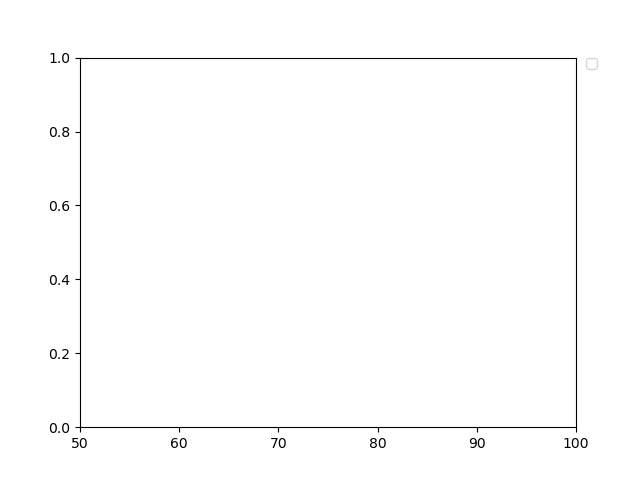

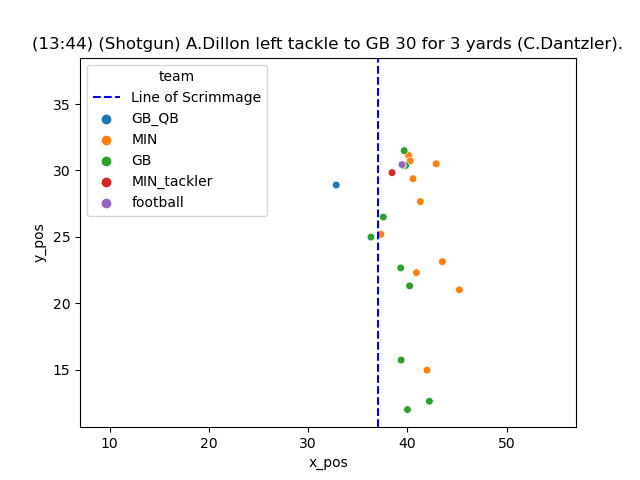

In [6]:
%matplotlib widget

#animate that
def plot_play(df, gameid=2022100908, playid=56):
    play1_plot = pd.DataFrame()
    game = df[df['gameId'] == gameid]
    play_1 = game[game['playId']==playid]
    game_tackles = tackles_df[tackles_df['gameId']==gameid]
    play_data = plays_df[(plays_df['playId']==playid) & (plays_df['gameId']==gameid)]
    yard_line = play_data['absoluteYardlineNumber'].values[0]


    for player in play_1['displayName'].unique():
        #first play,frame only test
        player_data = play_1[play_1['displayName']==player]
        for frame in player_data['frameId'].unique():
            index_name = player + '_' + str(frame)
            play1_plot.loc[index_name,'x_pos'] = player_data['x'].iloc[frame-1]
            play1_plot.loc[index_name,'y_pos'] = player_data['y'].iloc[frame-1]
            play1_plot.loc[index_name,'team'] = player_data['club'].iloc[frame-1]
            play1_plot.loc[index_name,'id'] = player_data['nflId'].iloc[frame-1]
            play1_plot.loc[index_name,'frame'] = frame

    for row in play1_plot.iterrows():
        if row[1]['id'] in game_tackles[game_tackles['playId']==playid]['nflId'].values:
            play1_plot.loc[row[0],'team'] = play1_plot.loc[row[0],'team'] + '_tackler'

    for row in play1_plot.iterrows():
        if row[1]['id'] in qb_df['nflId'].values:
            play1_plot.loc[row[0],'team'] = play1_plot.loc[row[0],'team'] + '_QB'

    
    print('Description:')
    print(play_data['playDescription'].values[0])

    plt.xlim(50, 100)
    plt.legend(["This is my legend"],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    fig = plt.figure()
    plt.title(play_data['playDescription'].values[0])
    #sns.scatterplot(data=play1_plot[play1_plot['frame']==1],x='x_pos',y='y_pos',hue='team',s=30)

    def update(frame):
        # for each frame, update the data stored on each artist.
        data = play1_plot[play1_plot['frame']==frame]
        ax=plt.gca()
        ax.clear()
        plt.xlim(yard_line-30, yard_line+20)
        plt.title(play_data['playDescription'].values[0])
        plt.axvline(x=yard_line, color='b',label='Line of Scrimmage',ls='--')
        plt.legend(["This is my legend"],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

        # update the scatter plot:
        return sns.scatterplot(data=data,x='x_pos',y='y_pos',hue='team',s=30)

    ani = animation.FuncAnimation(fig, update, frames=play1_plot['frame'].unique(), interval=200, repeat=True)
    writer = animation.PillowWriter(fps=15,
                                    metadata=dict(artist='Me'),
                                    bitrate=1800)


    
    ani.save('scatter2.gif', writer=writer)
    return HTML(ani.to_html5_video())


play_video = plot_play(week1_df,2022091112, 1994)
play_video

In [7]:
#Get distance to ball from tackler

def get_play(df, gameid, playid):
    play_df = df.copy()
    game = play_df[play_df['gameId'] == gameid]
    play = game[game['playId']==playid].copy()
    game_tackles = tackles_df[tackles_df['gameId']==gameid]

    tackler = game_tackles[game_tackles['playId']==playid]['nflId'].values[0]

    play.loc[:,'tackle'] = [ False if play_df['nflId'].iloc[i] != tackler else True for i in range(len(play))]
    # play_df['QB'] = False
    # for i in play_df['play']
    return play

play = get_play(week1_df,2022090800, 56)
#play1_plot['dist_to_ball'] = np.sqrt((play1_plot['x_pos']-play1_plot.loc['Tackler_1','x_pos'])**2 + (play1_plot['y_pos']-play1_plot.loc['Tackler_1','y_pos'])**2)


In [8]:
for frame in tqdm(play['frameId'].unique()):
    frames = play[play['frameId'] == frame]
    ball = frames[frames['displayName']=='football']

    for row in frames.iterrows():
        dist_to_ball = np.sqrt((row[1]['x']-ball['x'])**2 + (row[1]['y']-ball['y'])**2)
        play.loc[row[0],'dist_to_ball'] = dist_to_ball.values[0]

play[play['jerseyNumber'] == 14].head()

100%|██████████| 22/22 [00:00<00:00, 69.10it/s]


,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,tackle,dist_to_ball
88,2022090800,56,42489.0,Stefon Diggs,1,2022-09-08 20:24:05.200000,14.0,BUF,left,80.60,38.29,6.23,0.90,0.62,140.05,189.38,NaN,False,6.314500
89,2022090800,56,42489.0,Stefon Diggs,2,2022-09-08 20:24:05.299999,14.0,BUF,left,80.48,37.68,6.24,1.27,0.62,134.22,191.08,pass_arrived,False,3.905304
90,2022090800,56,42489.0,Stefon Diggs,3,2022-09-08 20:24:05.400000,14.0,BUF,left,80.34,37.09,5.98,2.48,0.60,127.16,194.40,NaN,False,2.051827
91,2022090800,56,42489.0,Stefon Diggs,4,2022-09-08 20:24:05.500000,14.0,BUF,left,80.19,36.53,5.67,3.37,0.58,120.72,196.97,NaN,False,0.094339
92,2022090800,56,42489.0,Stefon Diggs,5,2022-09-08 20:24:05.599999,14.0,BUF,left,80.01,36.00,5.43,3.65,0.56,118.07,199.54,NaN,False,1.176137


## EDA on tackles data

This competition is focused only on tackles. I will look at those specifically


In [9]:
#Just some stats
print('Total number of plays: {}\n'.format(len(plays_df)))
touchdowns = find_play_type(plays_df,'touchdown')
passes = find_play_type(plays_df,'pass')


# plays with missed tackles
missed_tackles = tackles_df[tackles_df['pff_missedTackle'] == 1]
assisted_tackles = tackles_df[tackles_df['assist'] > 0]
forced_fumbles = tackles_df[tackles_df['forcedFumble'] == 1]

print('\nNumber of missed tackles: {}'.format(len(missed_tackles)))
print('Number of assisted tackles: {}'.format(len(assisted_tackles)))
print('Number of forced fumbles: {}'.format(len(forced_fumbles)))

Total number of plays: 12486

Number of matches for touchdown: 429
Number of matches for pass: 5646

Number of missed tackles: 2090
Number of assisted tackles: 5494
Number of forced fumbles: 99


Description:
(8:57) D.Carr pass short middle to D.Waller to LV 45 for 15 yards (N.Adderley).


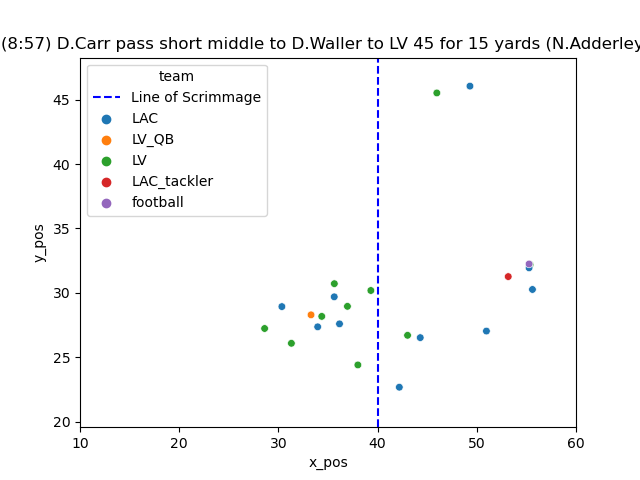

In [10]:
plot_play(week1_df,2022091111, 1148)